In [1]:
%matplotlib  inline
import pandas as pd
from datetime import datetime, timedelta
from functools import partial
import time
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from math import sqrt
import plotly as py
from plotly import tools
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import plotly.graph_objs as go
from joblib import Parallel, delayed
import scipy.ndimage as ndimage

    
import xgboost
import sklearn.feature_selection as fs
import sklearn.model_selection as ms
from sklearn import linear_model
from sklearn.metrics import r2_score
from sklearn.ensemble import ExtraTreesRegressor
import sklearn.preprocessing as prep
from sklearn.metrics import mean_squared_error

from pykalman import KalmanFilter
pd.set_option('display.max_columns', 150)
pd.options.display.max_rows = 150


C:\Users\prof\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:29: DeprecationWarning:

numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.



In [134]:
def macd(close, n_fast=12, n_slow=26,  n_sign=9, fillna=True):
    emafast = close.ewm(n_fast).mean()
    emaslow = close.ewm(n_slow).mean()
    macd = emafast - emaslow
    if fillna:
        macd = macd.fillna(0)
    macdsig = macd.ewm(n_sign).mean()
    if fillna:
        macd = macd.fillna(0)
        macdsig = macdsig.fillna(0)
    return macd, macdsig

def simple_returns(df):
    df = df.pct_change().fillna(0)
    return df

def rsi(close, period=14, fillna=True):
    diff = close.diff()
    which_dn = diff < 0

    up, dn = diff, diff*0
    up[which_dn], dn[which_dn] = 0, -up[which_dn]

    emaup = up.ewm(period).mean()
    emadn = dn.ewm(period).mean()

    rsi = 100 * emaup/(emaup + emadn)
    if fillna:
        rsi = rsi.fillna(50)
    return pd.Series(rsi, name='rsi')

def wavetrend(high,low,close,n1=10,n2=21):
    ap = (high+low+close)/3
    esa = close.ewm(n1).mean()
    d = abs(ap - esa).ewm(n1).mean()
    ci = (ap - esa) / (0.02 * d)
    tci = ci.ewm(n2).mean()
    
    wt1=tci
    wt2=wt1.rolling(n2).mean()
    wt2=wt2.fillna(method ='backfill')
    return wt1, wt2

def log_returns(df):

    log_ret = np.log(df) - np.log(df.shift(1))
    return log_ret

def tsi(close, r=25, s=13, fillna=True):

    m = close - close.shift(1)
    m1 = m.ewm(r).mean().ewm(s).mean()
    m2 = abs(m).ewm(r).mean().ewm(s).mean()
    tsi = m1/m2
    if fillna:
        tsi = tsi.fillna(0)
    return pd.Series(100*tsi, name='tsi')

def on_balance_volume(close, volume):

    df = pd.DataFrame([close, volume]).transpose()
    df['OBV'] = 0
    c1 = close < close.shift(1)
    c2 = close > close.shift(1)
    if c1.any():
        df.loc[c1, 'OBV'] = - volume
    if c2.any():
        df.loc[c2, 'OBV'] = volume
    return df['OBV']

def average_true_range(high, low, close, period=14, fillna=False):

    cs = close.shift(1)
    tr = high.combine(cs, max) - low.combine(cs, min)
    tr = tr.ewm(period).mean()
    if fillna:
        tr = tr.fillna(0)
    return pd.Series(tr, name='atr')

def kst(close, r1=10, r2=15, r3=20, r4=30, n1=10, n2=10, n3=10, n4=15, nsig=9, fillna=True):

    rocma1 = (close / close.shift(r1) - 1).rolling(n1).mean()
    rocma2 = (close / close.shift(r2) - 1).rolling(n2).mean()
    rocma3 = (close / close.shift(r3) - 1).rolling(n3).mean()
    rocma4 = (close / close.shift(r4) - 1).rolling(n4).mean()
    kst = 100*(rocma1 + 2*rocma2 + 3*rocma3 + 4*rocma4)
    sig = kst.rolling(nsig).mean()
    if fillna:
        sig = sig.fillna(0)
    return pd.Series(sig, name='sig')

def find_nearest(array, value,findMax=True):

    array = np.sort(np.asarray(array))
    if findMax:
        array = array[array>=value]
    else:
        array = array[array<=value]
    if array.size > 0:
        idx = (np.abs(array - value)).argmin()
        return array[idx]
    else:
        return np.nan

def local_extreme(array, min_distance = 20, periodic=False, edges_allowed=True,find_max=True): 
    """Find all local maxima of the array, separated by at least min_distance."""
    array = np.asarray(array)
    cval = 0 
    if periodic: 
        mode = 'wrap' 
    elif edges_allowed: 
        mode = 'nearest' 
    else: 
        mode = 'constant' 
    cval = array.max()+1 
    if find_max:
        max_points = array == ndimage.maximum_filter(array, 1+2*min_distance, mode=mode, cval=cval) 
    else:
        max_points = array == ndimage.minimum_filter(array, 1+2*min_distance, mode=mode, cval=cval) 
        
    return [indices[max_points] for indices in np.indices(array.shape)]

def extreme_significance(exArray, tolerance=0.02,signi_level=2):
    """Find Significance of extreme values within tolerance bound."""
    array = np.asarray(exArray)
    array = np.ravel(array)
    signifArr = np.zeros(len(array))
    d = {'data': array, 'sign': signifArr}
    result = pd.DataFrame(data=d).values
    #print('len of x is: '+repr(len(result)))
    for i in range(len(result)):
        val = result[i,0]
        signif = 0
        for j in range(i+1,len(result)):
            if (result[j,0]>= val*(1-tolerance)) and  (array[j]<= val*(1+tolerance)):
                    signif = signif + 1
            result[i,1] = signif
            
    result = pd.DataFrame(data=result,columns=['ExtremeValue', 'Significance'])
    result = result[result.Significance>=signi_level]
    return result.sort_values(by=['Significance'],ascending=False)

def grouper(iterable, tolerance):
    """Group extremes by cluster based on relative price distance."""
    # if Dataframe take first column
    if isinstance(iterable,pd.core.frame.DataFrame):
        iterable = iterable.sort_values(by=iterable.columns[0]).iloc[:,0].values
    elif isinstance(iterable,np.ndarray):
        iterable =np.sort(iterable)
    prev = None
    group = []
    for item in iterable:
        if not prev or item - prev <= tolerance*item:
            group.append(item)
        else:
            yield group
            group = [item]
        prev = item
    if group:
        yield group
def group_extremes(inp,max_distance):
    """Calculate centroid for each cluster of prices"""
    inp = dict(enumerate(grouper(inp,max_distance), 1))
    avgDict = {}
    for k,v in inp.items():
        # v is the list of items for dict row k
        avgDict[k] = sum(v)/ float(len(v))
    return list(avgDict.values())

def highest_high(df,period=21):
    df = df.rolling(window=period,center=False,min_periods=1).max()
    return df

def momentum(df,period=10):
    df = df - df.shift(period)
    df[0:period] = 0
    return df

def trading_range(df_high,df_low):
    df = df_high-df_low
    return df

def lowest_low(df,period=21):
    df = df.rolling(window=period,center=False,min_periods=1).min()
    return df

def calc_extreme_distance(series,sup_array,res_array):
    import math
    if isinstance(series,pd.core.frame.DataFrame):
        series = np.ravel(series.values())
    elif isinstance(series,np.ndarray):
        series =np.ravel(series)
    sup_array = np.ravel(np.array(sup_array))
    res_array = np.ravel(np.array(res_array))
    dist_s = []
    dist_r = []
    #if not sup_array:
    #    print("test")
    #else:
    for i in range(len(series)):
        curr_value = series[i]
        nearest_sup = find_nearest(sup_array, curr_value,findMax=False)
        nearest_res = find_nearest(res_array, curr_value)
        if curr_value*1.1 < nearest_sup:
            dist_s.append(curr_value/2)
        elif curr_value > nearest_res*1.1:
            dist_r.append(curr_value/2)
        else:
            sup_val = curr_value-nearest_sup
            res_val = nearest_res-curr_value
            if np.isnan(sup_val):
                sup_val = (curr_value/2)
            if np.isnan(res_val):
                res_val = (curr_value/2)
            dist_s.append(sup_val)
            dist_r.append(res_val)
    if dist_s and dist_r:
        return dist_s,dist_r
    
def r_score(y_true, y_pred, sample_weight=None, multioutput=None):
    r2 = r2_score(y_true, y_pred, sample_weight=sample_weight, multioutput=multioutput)
    r = (np.sign(r2)*np.sqrt(np.abs(r2)))
    if r <= -1:
        return -1
    else:
        return r
    
def calc_r_score (actual_and_test):
    r = []
    r.append(0)
    for i in range(1,len(actual_and_test)):
        ri = r_score(actual_and_test[0:i,0],actual_and_test[0:i,1])
        if ri <= -1:
            ri = 0
        r.append(ri)
    return r

def calc_kalman(dataframe):
    if isinstance(dataframe,pd.core.frame.DataFrame) or isinstance(dataframe,pd.core.series.Series):
        array = dataframe.values
    else:
        array = dataframe
    kf = KalmanFilter(transition_matrices = [1],
                      observation_matrices = [1],
                      initial_state_mean = 0,
                      initial_state_covariance = 1,
                      observation_covariance=1,
                      transition_covariance=.01)
    state_means, _ = kf.filter(array)
    state_means = state_means.flatten()
    state_means = pd.DataFrame(data=state_means,index=dataframe.index)
    state_means.columns = ['KF']
    state_means["KF"][0:9]  = float(np.mean(state_means[9:15]).values)
    return state_means

def calc_extreme_groups (dataframe,find_max=True,mDistance = 100,tolerance=0.0009,signi_level=1):
    """Group extremes by cluster based on absolute price distance.
       Input: series or dataframe
       find_max: maximum (resistance) or minimum (suppport) search
       mDistance: minimumdistance in an array to find local extremes
       tolerance: tolerance level in percent to group other extremes
       signi_level: leave 1 """
    if isinstance(dataframe,pd.core.frame.DataFrame) or isinstance(dataframe,pd.core.series.Series):
        array = np.ravel(dataframe.values)     
    array = np.ravel(array[local_extreme(array,min_distance= mDistance,find_max=find_max)])
    signify =extreme_significance(array, tolerance=tolerance,signi_level=signi_level)
    extreme = group_extremes(signify,tolerance)
    return array,signify,extreme

def calc_next_extreme_distance (dataframe,extremes_sup=None,extremes_res=None):
    """Given a series and their supports and resistances
    calculate the distances to the next supports or resistances."""
    if isinstance(dataframe,pd.core.frame.DataFrame) or isinstance(dataframe,pd.core.series.Series):
        array = np.ravel(dataframe.values) 
    [sup,res] = calc_extreme_distance(array,extremes_sup,extremes_res) 
    sr = pd.DataFrame(data=np.transpose([sup,res]),index=dataframe.index )
    sr.columns = ['support_distance', 'resistance_distance']
    return sr

import pdb;
def calc_MNE(df):
    MNE_list = []
    time_list = []
    for i in range(len(df)-1):
        #if i % 50000 == 0:
            #print('rows processed: ' + str(i))
        end_trade = df['endtime'][i]
        signal = df['signal'][i]
        try:
            end_index = df.index.get_loc(end_trade)
        except:
            end_index = len(df)
        data = df[i+1:end_index+1]
        if signal == -1:
            MNE = data['HIGH'].max()
            index = data['HIGH'].idxmax()
        elif signal == 1:
            MNE = data['LOW'].min()
            index = data['LOW'].idxmin()
        else:
            MNE = 0
            print('signal is not -1 or 1')
        MNE_list.append(MNE)
        time_list.append(index)
    MNE_list.append(np.nan)
    time_list.append(np.nan)
    
    #print('lendf: '+ str(len(df)) + ', lenMNE: ' + str(len(MNE_list)) + ', lenMNEdist: ' + str(len(diff_list))  + ', lenMNE_time: ' + str(len(time_list)) )

    df['MNE'] = MNE_list
    diff_list = np.absolute(df['MNE']-df['start_price'])
    df['MNE_distance_from_start'] = diff_list
    df['MNE_time'] = time_list
    return df

def calc_profit_loss(i=None,data=None,profit=0.01):
    start = data['CLOSE'][i]
    starttime = data.index[i]
    if (i+1)>len(data):
        return
    search = data[i+1:]
    longvalue = float('NaN')
    shortvalue = float('NaN')
    # Search long takeprofits
    try:
        longtime = search[search['HIGH']>=start*(1+profit)].index[0]
        longvalue = search[search['HIGH']>=start*(1+profit)]
        longvalue = longvalue['HIGH'][0]        
    except Exception as e:
        ts = time.time()
        longtime = datetime.fromtimestamp(ts)
    # Search short takeprofits
    try:
        shorttime = search[search['LOW']<= start*(1-profit)].index[0]
        shortvalue = search[search['LOW']<= start*(1-profit)]
        shortvalue = shortvalue['LOW'][0]
    except Exception as e:
        ts = time.time()
        shorttime = datetime.fromtimestamp(ts)
    
    
    
    #print( "longtime=" + str(longtime) + ",shorttime=" + str(shorttime) + ", longvalue= " + str(longvalue) + ", shortvalue= " + str(shortvalue))
    #pdb.set_trace()
    # If long was hit first go long
    if longtime<shorttime:
        return starttime,longtime,1,((longtime-starttime).total_seconds())/3600,start,longvalue
    # If short was hit first go short
    elif longtime>shorttime:
        return starttime,shorttime,-1,((shorttime-starttime).total_seconds())/3600,start,shortvalue
    # if long and short is same hour meaning next candle hits SL and PT
    elif longtime.date()==shorttime.date() and longtime.hour == shorttime.hour:
        # if end of file has been reached
        
        if longtime.date()== datetime.now().date():
            if longtime.hour == datetime.now().hour:
                return starttime, data.index[len(data)-1],1, 1 ,start,data.CLOSE[len(data)-1]
            else:
                return starttime, data.index[len(data)-1],1, ((data.index[len(data)-1]-starttime).total_seconds())/3600 ,start,data.CLOSE[len(data)-1]
        # determine which signal to follow
        else:
            # if close is higher than start long
            if start <= data.loc[longtime].CLOSE:
                return starttime,longtime,1,((longtime-starttime).total_seconds())/3600,start,longvalue
            # if close is lower than start short
            else:
                return starttime,shorttime,-1,((shorttime-starttime).total_seconds())/3600,start,shortvalue
    
    
    
from pyti.stochrsi import stochrsi as stochrsi
from pyti.commodity_channel_index import commodity_channel_index as cci

def feature_engineering_dates(df):
    df['Year'] = df.index.year
    df['Month'] = df.index.month
    df['Week'] = df.index.weekofyear
    df['Weekday'] = df.index.weekday
    df['DayMonth'] = df.index.day
    return df

def feature_engineering_ta(df):

    df['TSI'] = tsi(df['CLOSE'])
    df['ATR'] = average_true_range(df['HIGH'],df['LOW'],df['CLOSE'],period=14)
    df['WT1'],df['WT2'] = wavetrend(df['HIGH'],df['LOW'],df['CLOSE'],n1=10,n2=21)
    df['KF'] = calc_kalman(df['CLOSE'])
    df['KST'] = kst(df['CLOSE'])
    df['HIGHESTHIGH'] = highest_high(df['HIGH'],period=21)
    df['LOWESTLOW'] = lowest_low(df['LOW'],period=21)
    df['TRADINGRANGE'] = trading_range(df['HIGH'],df['LOW'])
    df['MOMENTUM'] = momentum(df['CLOSE'],period=10)
    df['RSI'] = rsi(df['CLOSE'],period=14)
    df['MACD'],df['MACDSIGNAL'] = macd(df['CLOSE'])
    df['STOCHRSI'] = stochrsi(df['CLOSE'], 14)
    df['CCI'] = cci(df['CLOSE'],df['HIGH'],df['LOW'], 20)
    return df

def feature_engineering_statistics(df_grouped,cols):
    for c in cols:
        # rolling
        for h in [11, 21]:
            df_grouped[c+'_rolling_mean_'+str(h)] = df_grouped[c].rolling(h, min_periods=0).mean()
        # diffs
        df_grouped[c+'_diff_1'] = df_grouped[c].diff().fillna(method="backfill")
        df_grouped[c+'_diff_2'] = df_grouped[c].diff(2).fillna(method="backfill")
        df_grouped[c+'_diff_3'] = df_grouped[c].diff(3).fillna(method="backfill")
        # cumsum
        df_grouped[c+'_cumsum'] = df_grouped[c].cumsum()
        # shift columns
        df_grouped[c+'_shift1'] = df_grouped[c].shift(1).fillna(0)
        df_grouped[c+'_shift2'] = df_grouped[c].shift(2).fillna(0)
        df_grouped[c+'_shift3'] = df_grouped[c].shift(3).fillna(0)
    return df_grouped


In [3]:
EURUSD = pd.read_csv('EURUSD.txt',delimiter=',',dtype={'<TIME>': str})
EURUSD.columns = EURUSD.columns.str.replace("<", "")
EURUSD.columns = EURUSD.columns.str.replace(">", "")
EURUSD = EURUSD.drop(['VOL'], axis=1)
EURUSD['DATETIME'] = EURUSD['DTYYYYMMDD'].astype(str) + ":" + EURUSD['TIME'].astype(str)
EURUSD = EURUSD.drop(['DTYYYYMMDD','TIME'], axis=1)
EURUSD['DATETIME']  = pd.to_datetime(EURUSD['DATETIME'],format='%Y%m%d:%H%M%S',  infer_datetime_format=False)
EURUSD.index = pd.to_datetime(EURUSD['DATETIME'],format='%Y%m%d:%H%M%S',  infer_datetime_format=False, unit="m")

In [4]:
EURUSD_1H = EURUSD.resample('1H').agg({'OPEN': 'first', 
                                 'HIGH': 'max', 
                                 'LOW': 'min', 
                                 'CLOSE': 'last'})

EURUSD_4H = EURUSD.resample('4H').agg({'OPEN': 'first', 
                                 'HIGH': 'max', 
                                 'LOW': 'min', 
                                 'CLOSE': 'last'})

EURUSD_D = EURUSD.resample('1D').agg({'OPEN': 'first',
                                 'HIGH': 'max', 
                                 'LOW': 'min', 
                                 'CLOSE': 'last'})
EURUSD_D = EURUSD_D.pct_change().dropna()
EURUSD_D['Weekday'] = EURUSD_D.index.weekday
EURUSD_D['Month'] = EURUSD_D.index.month
EURUSD_D['DayMonth'] = EURUSD_D.index.day

EURUSD_1H = EURUSD_1H.dropna()
EURUSD_4H = EURUSD_4H.dropna()

EURUSD_M = EURUSD_1H.resample('M').agg({'OPEN': 'first',
                                 'HIGH': 'max', 
                                 'LOW': 'min', 
                                 'CLOSE': 'last'})
EURUSD_M = EURUSD_M.dropna().pct_change().dropna()
EURUSD_M['Month'] = EURUSD_M.index.month

# local extremes

C:\Users\prof\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:6: FutureWarning:

Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.

C:\Users\prof\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:8: FutureWarning:

Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.



Text(0.5,1,'Local extremes')

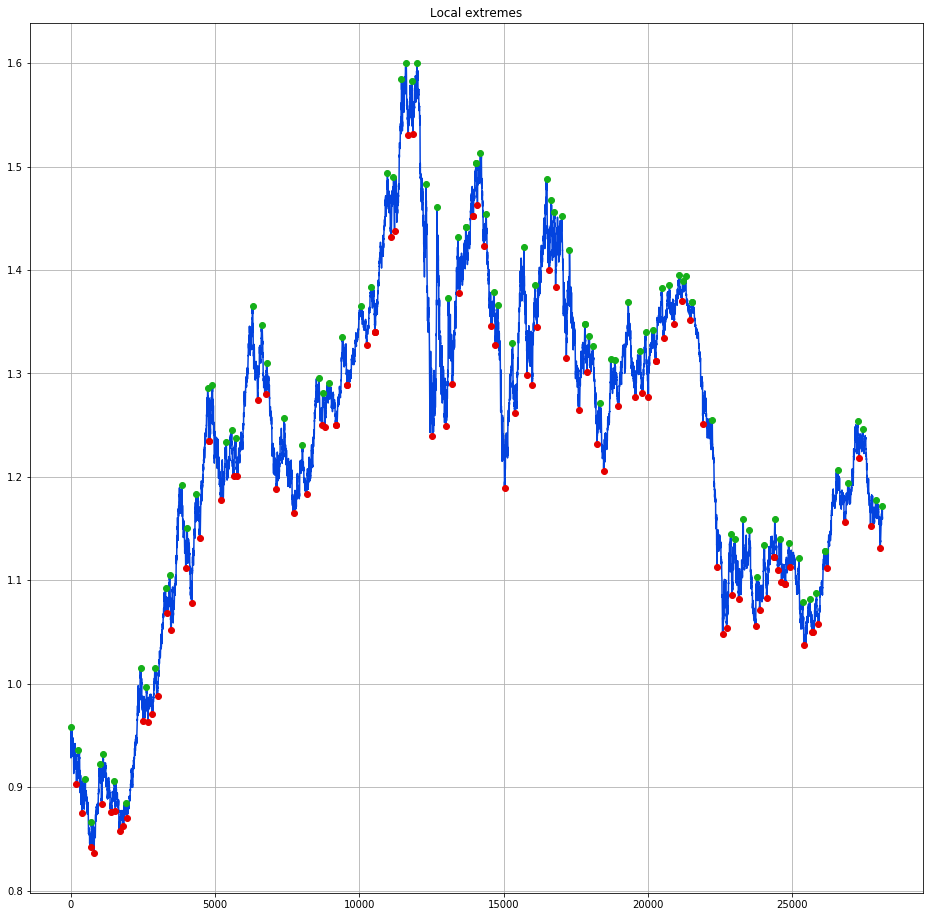

In [5]:
cl=np.ravel(EURUSD_4H[['CLOSE']].values)
plt.rc("figure",figsize=(16,16))
plt.plot(cl,color='xkcd:blue',linestyle ='-')
mDistance = 100
plt.plot(np.ravel(local_extreme(cl,min_distance= mDistance,find_max=True)),
         np.ravel(cl[local_extreme(cl,min_distance= mDistance,find_max=True)]) ,color='xkcd:green',marker='o',linestyle ='')
plt.plot(np.ravel(local_extreme(cl,min_distance= mDistance,find_max=False)),
         np.ravel(cl[local_extreme(cl,min_distance= mDistance,find_max=False)]) ,color='xkcd:red',marker='o',linestyle ='')
plt.grid(True)
plt.title("Local extremes")

# resistance levels

localextremes:100
signify:27  signimax:4.0
extremes:18


C:\Users\prof\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:4: FutureWarning:

Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.

C:\Users\prof\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:265: FutureWarning:

Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.



Text(0.5,1,'resistances')

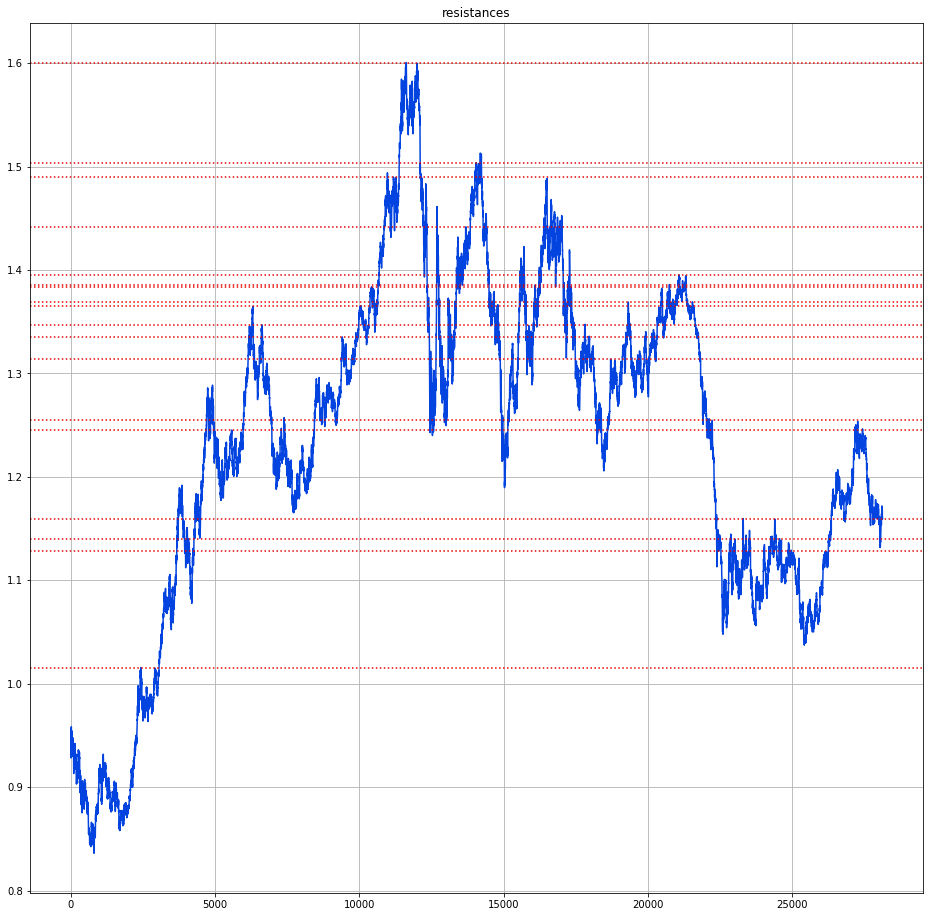

In [6]:
tolerance= 0.001
signi_level=1
min_distance= 100
array = np.ravel(cl[local_extreme(cl,min_distance= min_distance,find_max=False)])
#signify =extreme_significance(array, tolerance=tolerance,signi_level=signi_level)
signify =extreme_significance(array, tolerance=tolerance,signi_level=signi_level)
extreme = group_extremes(signify,tolerance)
print('localextremes:' + repr(len(array)))
print('signify:' + repr(len(signify)), ' signimax:' +repr(np.max(signify['Significance'])))
print('extremes:' + repr(len(extreme)))
      
_,_,extremes_res = calc_extreme_groups(EURUSD_4H[['CLOSE']],signi_level=signi_level,
                                   tolerance=tolerance,mDistance = min_distance,find_max=True)
plt.rc("figure",figsize=(16,16))
plt.plot(cl,color='xkcd:blue',linestyle ='-')
yval = np.ravel(extremes_res)
for x in yval:
    plt.axhline(y=x,color='xkcd:red',linestyle =':')
plt.grid(True)
plt.title("resistances")

# Support levels

localextremes:100
signify:27  signimax:4.0
extremes:18


C:\Users\prof\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:265: FutureWarning:

Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.



Text(0.5,1,'Supports')

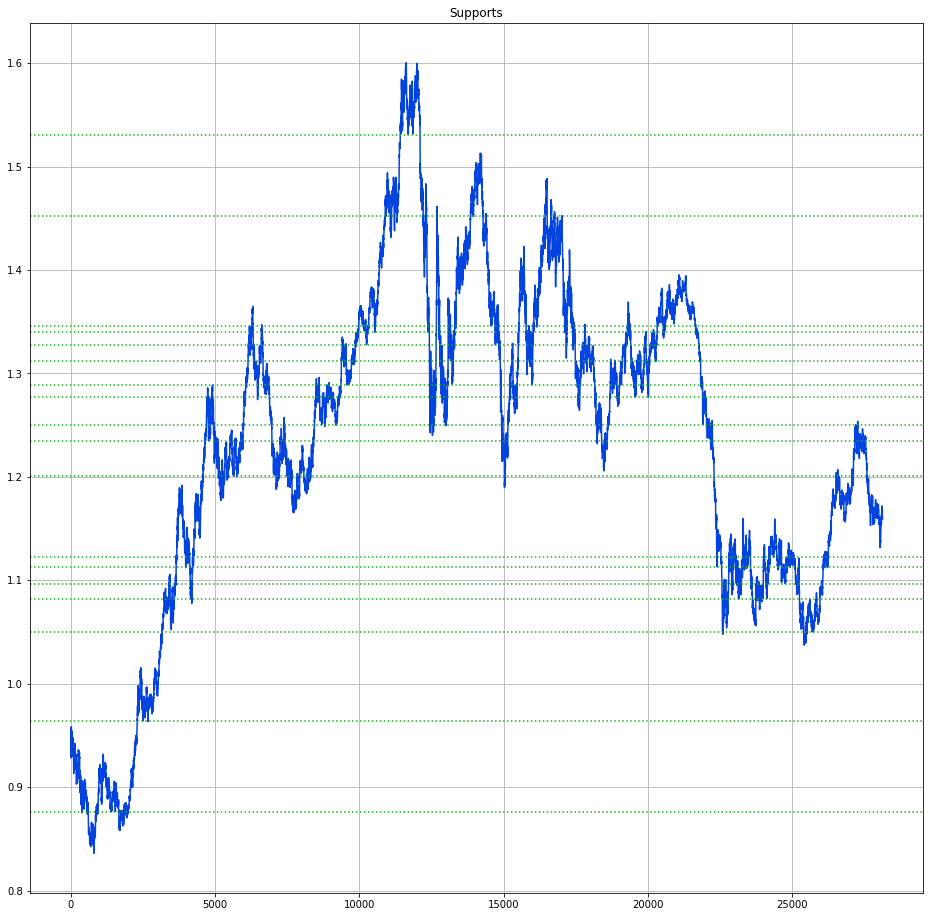

In [7]:
# Show horizontal resistance levels based on extreme points and significance
__,__,extremes_sup = calc_extreme_groups(EURUSD_4H[['CLOSE']],signi_level=signi_level,
                                   tolerance=tolerance,mDistance = min_distance,find_max=False)
plt.rc("figure",figsize=(16,16))
plt.plot(cl,color='xkcd:blue',linestyle ='-')
yval = np.ravel(extremes_sup)
print('localextremes:' + repr(len(array)))
print('signify:' + repr(len(signify)), ' signimax:' +repr(np.max(signify['Significance'])))
print('extremes:' + repr(len(extreme)))
for x in yval:
    plt.axhline(y=x,color='xkcd:green',linestyle =':')
plt.grid(True)
plt.title("Supports")

# add indicators

In [8]:
EURUSD_4H = feature_engineering_dates(EURUSD_4H)
EURUSD_4H = feature_engineering_ta(EURUSD_4H)
EURUSD_4H = EURUSD_4H.fillna(method='bfill')

EURUSD_1H = feature_engineering_dates(EURUSD_1H)
EURUSD_1H = feature_engineering_ta(EURUSD_1H)
EURUSD_1H = EURUSD_1H.fillna(method='bfill')
#cols = ['TSI','ATR','KF','KST','HIGHESTHIGH','LOWESTLOW','TRADINGRANGE','MOMENTUM','RSI','MACD','MACDSIGNAL','WT1','WT2','STOCHRSI','CCI']
#EURUSD_1H = feature_engineering_statistics(EURUSD_1H,cols)

# Create target

In [56]:
profit = 0.0016 # in EURUSD absolute Notation 
data = EURUSD_1H[['HIGH','LOW','CLOSE']]
start = time.time()
inputs = range(len(data))

try:
    df = pd.read_pickle('results.pkl')
except:
    results = Parallel(n_jobs=6,verbose=1)(delayed(calc_profit_loss)(x, data, profit) for x in inputs)
    end = time.time()
    print('- time elapsed in seconds: ' + str(end - start))
    results = [x for x in results if x is not None]
    results = [x for x in results if str(x) != 'nan']
    df = pd.DataFrame(results, columns=['pos','endtime','signal', 'time_diff_hours','start_price','end_price'])
    df.index = df['pos']
    df = df.drop(['pos'], axis=1)
    df.to_pickle('results.pkl')

data_merged = EURUSD_1H.merge(df, left_index=True,right_index =True, how='left')
#data_merged = data_merged.dropna()
data_merged = data_merged[data_merged['time_diff_hours'] !=0]
data_merged['pct_change'] = (data_merged['end_price']/data_merged['start_price'])-1
data_merged['weight'] = 1/data_merged['time_diff_hours']
data_merged['weighted_target'] = data_merged['weight']*data_merged['pct_change']
data_merged.to_csv('EURUSD_1H_signal_data.csv',index =True,index_label='DATETIME')

print('-- mean holding time in hours: ' + str(data_merged.time_diff_hours.mean()))
print('-- number of holding time between 5 and 10 hrs: ' + str(data_merged.OPEN[(data_merged.time_diff_hours >=4) & (data_merged.time_diff_hours <=12)].count()))
print('--- number of holding time > 100 hours: ' + str(data_merged.OPEN[data_merged.time_diff_hours > 100].count()))

# candle big enough to reach SL or TP in 1 move
print('--- number of 1 hour holding time: ' + str(data_merged[data_merged['time_diff_hours'] ==1].signal.count()))

print('---- rowcount of 3B-results: ' + str(len(results)) + '\n---- rowcount of original input: ' + str(len(EURUSD_1H)) + '\n---- rowcount of merged: ' + str(len(data_merged)))

-- mean holding time in hours: 6.772801387760034
-- number of holding time between 5 and 10 hrs: 37653
--- number of holding time > 100 hours: 17
--- number of 1 hour holding time: 27284
---- rowcount of 3B-results: 108238
---- rowcount of original input: 108238
---- rowcount of merged: 108238


# plot example for wave trend

In [57]:
start = EURUSD_1H.index.searchsorted(datetime(2001, 1, 3, 18))
end = EURUSD_1H.index.searchsorted(datetime(2001, 1, 4, 12))
EURUSD_temp =EURUSD_1H.iloc[start:end]

init_notebook_mode(connected=True)
data = go.Candlestick(x=EURUSD_temp.index, open=EURUSD_temp['OPEN'],high=EURUSD_temp['HIGH'],low=EURUSD_temp['LOW'],
                      close=EURUSD_temp['CLOSE'])

wt1 = go.Scatter(
    x=EURUSD_temp.index,
    y=EURUSD_temp['WT1'],
    name = 'WT1'
)

wt2 = go.Scatter(
    x=EURUSD_temp.index,
    y=EURUSD_temp['WT2'],
    name = 'WT2'
)
wt3 = go.Scatter(
    x=EURUSD_temp.index,
    y=EURUSD_temp['STOCHRSI'],
    name = 'STOCHRSI'
)
#py.plotly.iplot(wt,filename='basic_candle', auto_open=True)
fig = tools.make_subplots(rows=2, cols=1)
fig.append_trace(data, 1, 1)
fig.append_trace(wt1, 2, 1)
fig.append_trace(wt2, 2, 1)
#fig.append_trace(wt3, 2, 1)
py.offline.iplot(fig,filename='basic_candle')

This is the format of your plot grid:
[ (1,1) x1,y1 ]
[ (2,1) x2,y2 ]



In [58]:
profit = 0.0016 # in EURUSD absolute Notation 
temp = EURUSD_1H[['HIGH','LOW','CLOSE']]
inputs = range(len(temp))

#temp = temp[['HIGH','LOW','CLOSE']]
#inputs = range(len(temp))
#print(temp)
#profit = 0.0016 # in EURUSD absolute Notation 
#temp_results = Parallel(n_jobs=4,verbose=1)(delayed(calc_profit_loss)(x, temp, profit) for x in inputs)
for i in inputs:
    temp_results = calc_profit_loss(i, temp, profit)
end
#temp_df = pd.DataFrame(data=temp_results,columns=['starttime', 'endtime', 'signal', 'hours_distance', 'startval','endval'])
#temp_df
#temp.loc['2001-01-03 19:00:00']
#temp_results

37

# Seasonality in the performance?

# mean weekday performance strategy

Text(0.5,1,'Mean close to close return per weekda')

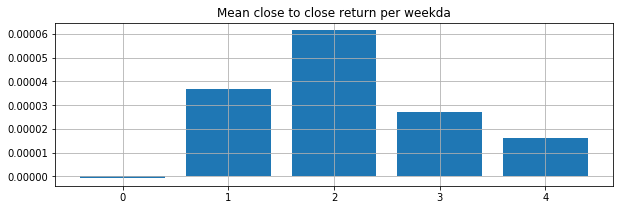

In [59]:
bars = data_merged[data_merged.Weekday <=5].groupby(['Weekday'])['pct_change'].mean()
plt.rc("figure",figsize=(10,3))
plt.bar(bars.index,bars)
plt.grid()
plt.title('Mean close to close return per weekday')

# mean weekday performance day to day

Text(0.5,1,'Mean day close to day close return per weekday')

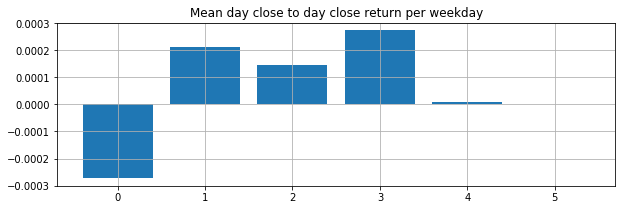

In [60]:
bars = EURUSD_D[EURUSD_D.Weekday <=5].groupby(['Weekday'])['CLOSE'].mean()
plt.rc("figure",figsize=(10,3))
plt.bar(bars.index,bars)
plt.grid()
plt.title('Mean day close to day close return per weekday')

# sum weekday signal strategy

Text(0.5,1,'Bar 6 = Sunday 23:00')

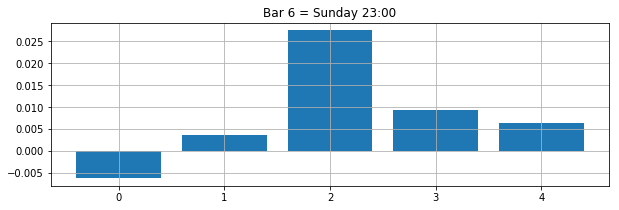

In [74]:
bars = data_merged[data_merged.Weekday <=5].groupby(['Weekday'])['signal'].mean()
plt.rc("figure",figsize=(10,3))
plt.bar(bars.index,bars)
plt.grid()
plt.title('Bar 6 = Sunday 23:00')

# mean daymonth performance strategy

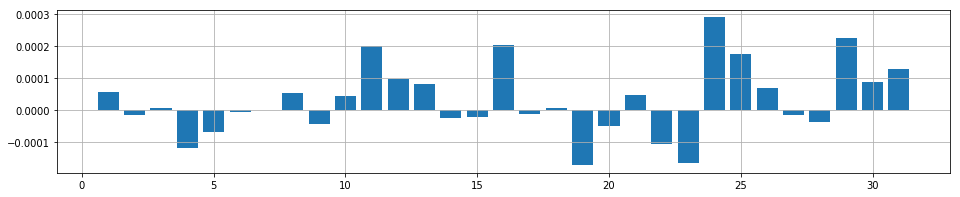

In [75]:
bars = data_merged.groupby(['DayMonth'])['pct_change'].mean()
plt.rc("figure",figsize=(16,3))
plt.bar(bars.index,bars)
plt.grid()

# mean daymonth performance day to day

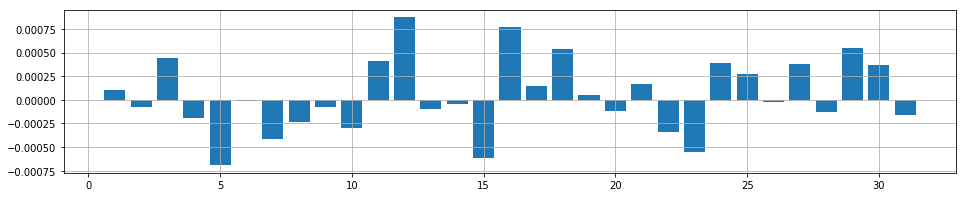

In [76]:
bars = EURUSD_D.groupby(['DayMonth'])['CLOSE'].mean()
plt.rc("figure",figsize=(16,3))
plt.bar(bars.index,bars)
plt.grid()

# sum month signal strategy

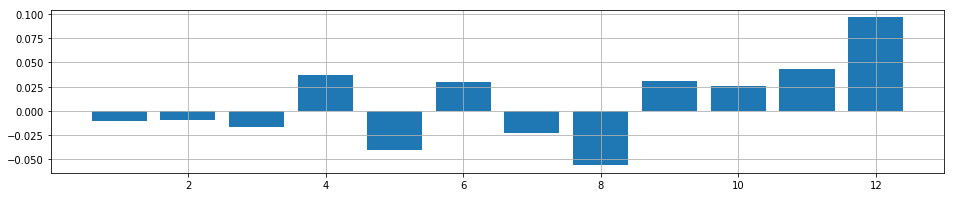

In [77]:
bars = data_merged.groupby(['Month'])['signal'].mean()
plt.rc("figure",figsize=(16,3))
plt.bar(bars.index,bars)
plt.grid()

# mean month performance month to month

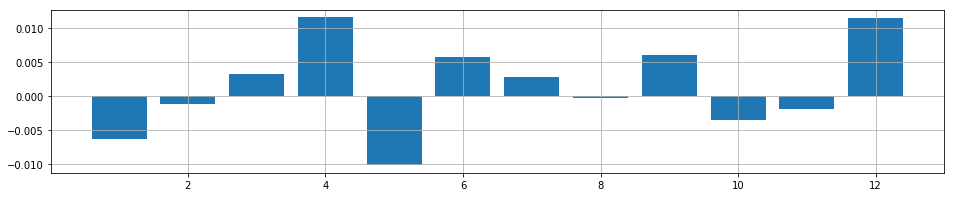

In [78]:
bars = EURUSD_M.groupby(['Month'])['CLOSE'].mean()
plt.rc("figure",figsize=(16,3))
plt.bar(bars.index,bars)
plt.grid()

# summary

In [67]:
data_merged.head(32)

,OPEN,HIGH,LOW,CLOSE,Year,Month,Week,Weekday,DayMonth,TSI,ATR,WT1,WT2,KF,KST,HIGHESTHIGH,LOWESTLOW,TRADINGRANGE,MOMENTUM,RSI,MACD,MACDSIGNAL,STOCHRSI,CCI,endtime,signal,time_diff_hours,start_price,end_price,pct_change,weight,weighted_target
DATETIME,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2001-01-02 23:00:00,0.9507,0.9509,0.9505,0.9506,2001,1,1,1,2,0.000000,0.000400,50.000000,32.504318,0.896865,0.0,0.9509,0.9505,0.0004,0.0000,50.000000,0.000000e+00,0.000000e+00,26.744514,-6.282550,2001-01-03 07:00:00,-1,8.0,0.9506,0.9468,-0.003997,0.125000,-0.000500
2001-01-03 00:00:00,0.9506,0.9510,0.9492,0.9496,2001,1,1,2,3,-100.000000,0.001124,-9.871351,32.504318,0.896865,0.0,0.9510,0.9492,0.0018,0.0000,0.000000,-1.056604e-05,-5.561072e-06,26.744514,-6.282550,2001-01-03 06:00:00,1,6.0,0.9496,0.9513,0.001790,0.166667,0.000298
2001-01-03 01:00:00,0.9496,0.9509,0.9495,0.9505,2001,1,1,2,3,-51.126361,0.001223,6.524603,32.504318,0.896865,0.0,0.9510,0.9492,0.0014,0.0000,49.090909,-8.826300e-07,-3.834710e-06,26.744514,-6.282550,2001-01-03 07:00:00,-1,6.0,0.9505,0.9468,-0.003893,0.166667,-0.000649
2001-01-03 02:00:00,0.9504,0.9508,0.9498,0.9499,2001,1,1,2,3,-43.544379,0.001161,10.228013,32.504318,0.896865,0.0,0.9510,0.9492,0.0010,0.0000,36.346154,-6.097027e-06,-4.492551e-06,26.744514,-6.282550,2001-01-03 07:00:00,-1,5.0,0.9499,0.9468,-0.003264,0.200000,-0.000653
2001-01-03 03:00:00,0.9499,0.9507,0.9499,0.9503,2001,1,1,2,3,-35.510076,0.001079,23.696245,32.504318,0.896865,0.0,0.9510,0.9492,0.0008,0.0000,46.303592,-1.897504e-06,-3.858856e-06,26.744514,-6.282550,2001-01-03 07:00:00,-1,4.0,0.9503,0.9468,-0.003683,0.250000,-0.000921
2001-01-03 04:00:00,0.9503,0.9506,0.9503,0.9506,2001,1,1,2,3,-28.715653,0.000925,37.938837,32.504318,0.896865,0.0,0.9510,0.9492,0.0003,0.0000,52.299689,6.471643e-06,-1.654118e-06,26.744514,-6.282550,2001-01-03 07:00:00,-1,3.0,0.9506,0.9468,-0.003997,0.333333,-0.001332
2001-01-03 05:00:00,0.9506,0.9507,0.9505,0.9505,2001,1,1,2,3,-24.837550,0.000799,46.394716,32.504318,0.896865,0.0,0.9510,0.9492,0.0002,0.0000,50.293920,1.015981e-05,6.103740e-07,26.744514,-6.282550,2001-01-03 07:00:00,-1,2.0,0.9505,0.9468,-0.003893,0.500000,-0.001946
2001-01-03 06:00:00,0.9505,0.9513,0.9503,0.9509,2001,1,1,2,3,-20.212647,0.000831,55.777291,32.504318,0.896865,0.0,0.9513,0.9492,0.0010,0.0000,57.310509,2.095580e-05,4.182675e-06,26.744514,-6.282550,2001-01-03 07:00:00,-1,1.0,0.9509,0.9468,-0.004312,1.000000,-0.004312
2001-01-03 07:00:00,0.9510,0.9510,0.9468,0.9489,2001,1,1,2,3,-22.200497,0.001316,25.059167,32.504318,0.896865,0.0,0.9513,0.9468,0.0042,0.0000,32.632826,-1.358740e-05,1.281814e-06,26.744514,-6.282550,2001-01-03 08:00:00,1,1.0,0.9489,0.9543,0.005691,1.000000,0.005691


In [68]:
data_merged.describe()

,OPEN,HIGH,LOW,CLOSE,Year,Month,Week,Weekday,DayMonth,TSI,ATR,WT1,WT2,KF,KST,HIGHESTHIGH,LOWESTLOW,TRADINGRANGE,MOMENTUM,RSI,MACD,MACDSIGNAL,STOCHRSI,CCI,signal,time_diff_hours,start_price,end_price,pct_change,weight,weighted_target
count,108238.000000,108238.000000,108238.000000,108238.000000,108238.000000,108238.000000,108238.000000,108238.000000,108238.000000,108238.000000,108238.000000,108238.000000,108238.000000,108238.000000,108238.000000,108238.000000,108238.000000,108238.000000,108238.000000,108238.000000,108238.000000,108238.000000,108238.000000,108238.000000,108238.000000,108238.000000,108238.000000,108236.000000,108236.000000,108238.000000,108236.000000
mean,1.232074,1.233058,1.231099,1.232077,2009.336536,6.431632,26.229088,2.006772,15.700678,0.517403,0.001973,1.346631,1.352304,1.232047,0.061463,1.237282,1.226829,0.001958,0.000020,50.255535,0.000028,0.000029,50.169815,0.008632,0.007465,6.772801,1.232077,1.232105,0.000027,0.444835,0.000010
std,0.159876,0.160008,0.159734,0.159872,5.092055,3.412439,14.878914,1.461929,8.757236,16.442612,0.000878,29.956505,28.146389,0.159874,4.755534,0.160525,0.159197,0.001576,0.004987,12.679456,0.002484,0.002335,36.032797,2.020301,0.999977,12.901666,0.159872,0.159869,0.002749,0.351540,0.001669
min,0.835500,0.836200,0.835000,0.835400,2001.000000,1.000000,1.000000,0.000000,1.000000,-100.000000,0.000400,-71.715085,-65.806085,0.837519,-27.782880,0.840400,0.835000,0.000000,-0.041700,0.000000,-0.013403,-0.012318,0.000000,-17.787085,-1.000000,1.000000,0.835400,0.835100,-0.021386,0.000851,-0.021386
25%,1.126600,1.127500,1.125800,1.126600,2005.000000,3.000000,13.000000,1.000000,8.000000,-11.059933,0.001389,-23.975125,-22.196844,1.126325,-2.593164,1.131700,1.121600,0.000900,-0.002300,41.352651,-0.001372,-0.001299,15.651393,-1.004061,-1.000000,1.000000,1.126600,1.126800,-0.002130,0.142857,-0.000738
50%,1.254300,1.255300,1.253300,1.254300,2009.000000,6.000000,26.000000,2.000000,16.000000,0.832157,0.001782,1.970412,2.215162,1.254437,0.127900,1.260050,1.249500,0.001500,0.000000,50.339361,0.000099,0.000108,50.317244,0.030426,1.000000,3.000000,1.254300,1.254400,0.001605,0.333333,0.000029
75%,1.343400,1.344300,1.342500,1.343400,2014.000000,9.000000,39.000000,3.000000,23.000000,12.128933,0.002322,26.662483,24.521777,1.343464,2.787176,1.347800,1.338000,0.002500,0.002400,59.194807,0.001530,0.001443,84.817573,1.047526,1.000000,7.000000,1.343400,1.342900,0.002148,1.000000,0.000760
max,1.601400,1.603600,1.599000,1.601300,2018.000000,12.000000,53.000000,6.000000,31.000000,53.514986,0.009999,74.035459,67.491931,1.596783,30.007173,1.603600,1.593500,0.033100,0.049300,92.171446,0.020723,0.019505,100.000000,19.485730,1.000000,1175.238304,1.601300,1.603600,0.023543,1.000000,0.023543


In [69]:
data_merged[data_merged['time_diff_hours'] ==1]

,OPEN,HIGH,LOW,CLOSE,Year,Month,Week,Weekday,DayMonth,TSI,ATR,WT1,WT2,KF,KST,HIGHESTHIGH,LOWESTLOW,TRADINGRANGE,MOMENTUM,RSI,MACD,MACDSIGNAL,STOCHRSI,CCI,endtime,signal,time_diff_hours,start_price,end_price,pct_change,weight,weighted_target
DATETIME,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2001-01-03 06:00:00,0.9505,0.9513,0.9503,0.9509,2001,1,1,2,3,-20.212647,0.000831,55.777291,32.504318,0.896865,0.000000,0.9513,0.9492,0.0010,0.0000,57.310509,0.000021,0.000004,26.744514,-6.282550,2001-01-03 07:00:00,-1,1.0,0.9509,0.9468,-0.004312,1.0,-0.004312
2001-01-03 07:00:00,0.9510,0.9510,0.9468,0.9489,2001,1,1,2,3,-22.200497,0.001316,25.059167,32.504318,0.896865,0.000000,0.9513,0.9468,0.0042,0.0000,32.632826,-0.000014,0.000001,26.744514,-6.282550,2001-01-03 08:00:00,1,1.0,0.9489,0.9543,0.005691,1.0,0.005691
2001-01-03 09:00:00,0.9539,0.9549,0.9526,0.9541,2001,1,1,2,3,-0.458289,0.001917,53.499517,32.504318,0.887400,0.000000,0.9549,0.9468,0.0023,0.0035,69.417663,0.000138,0.000030,26.744514,-6.282550,2001-01-03 10:00:00,1,1.0,0.9541,0.9565,0.002515,1.0,0.002515
2001-01-03 10:00:00,0.9542,0.9565,0.9534,0.9565,2001,1,1,2,3,8.629703,0.002057,63.451395,32.504318,0.895082,0.000000,0.9565,0.9468,0.0031,0.0069,76.265378,0.000247,0.000060,26.744514,-6.282550,2001-01-03 11:00:00,-1,1.0,0.9565,0.9541,-0.002509,1.0,-0.002509
2001-01-03 11:00:00,0.9564,0.9569,0.9541,0.9547,2001,1,1,2,3,12.032576,0.002141,67.460460,32.504318,0.901525,0.000000,0.9569,0.9468,0.0028,0.0042,64.635603,0.000291,0.000091,26.744514,-6.282550,2001-01-03 12:00:00,-1,1.0,0.9547,0.9527,-0.002095,1.0,-0.002095
2001-01-03 12:00:00,0.9548,0.9549,0.9527,0.9527,2001,1,1,2,3,11.855551,0.002147,64.854505,32.504318,0.906930,0.000000,0.9569,0.9468,0.0022,0.0028,54.704691,0.000278,0.000115,26.744514,-6.282550,2001-01-03 13:00:00,-1,1.0,0.9527,0.9503,-0.002519,1.0,-0.002519
2001-01-03 13:00:00,0.9528,0.9533,0.9503,0.9513,2001,1,1,2,3,10.227008,0.002236,57.030706,32.504318,0.911528,0.000000,0.9569,0.9468,0.0030,0.0010,49.052232,0.000231,0.000130,26.744514,-6.282550,2001-01-03 14:00:00,-1,1.0,0.9513,0.9475,-0.003995,1.0,-0.003995
2001-01-03 14:00:00,0.9513,0.9520,0.9475,0.9491,2001,1,1,2,3,7.014706,0.002461,45.045513,32.504318,0.915361,0.000000,0.9569,0.9468,0.0045,-0.0015,41.783260,0.000138,0.000131,26.744514,-6.282550,2001-01-03 15:00:00,-1,1.0,0.9491,0.9444,-0.004952,1.0,-0.004952
2001-01-03 16:00:00,0.9460,0.9477,0.9450,0.9473,2001,1,1,2,3,-0.329852,0.002741,20.227978,32.504318,0.921343,0.000000,0.9569,0.9444,0.0027,-0.0036,38.852708,-0.000114,0.000087,26.744514,-6.282550,2001-01-03 17:00:00,-1,1.0,0.9473,0.9446,-0.002850,1.0,-0.002850


# correlations with signal?

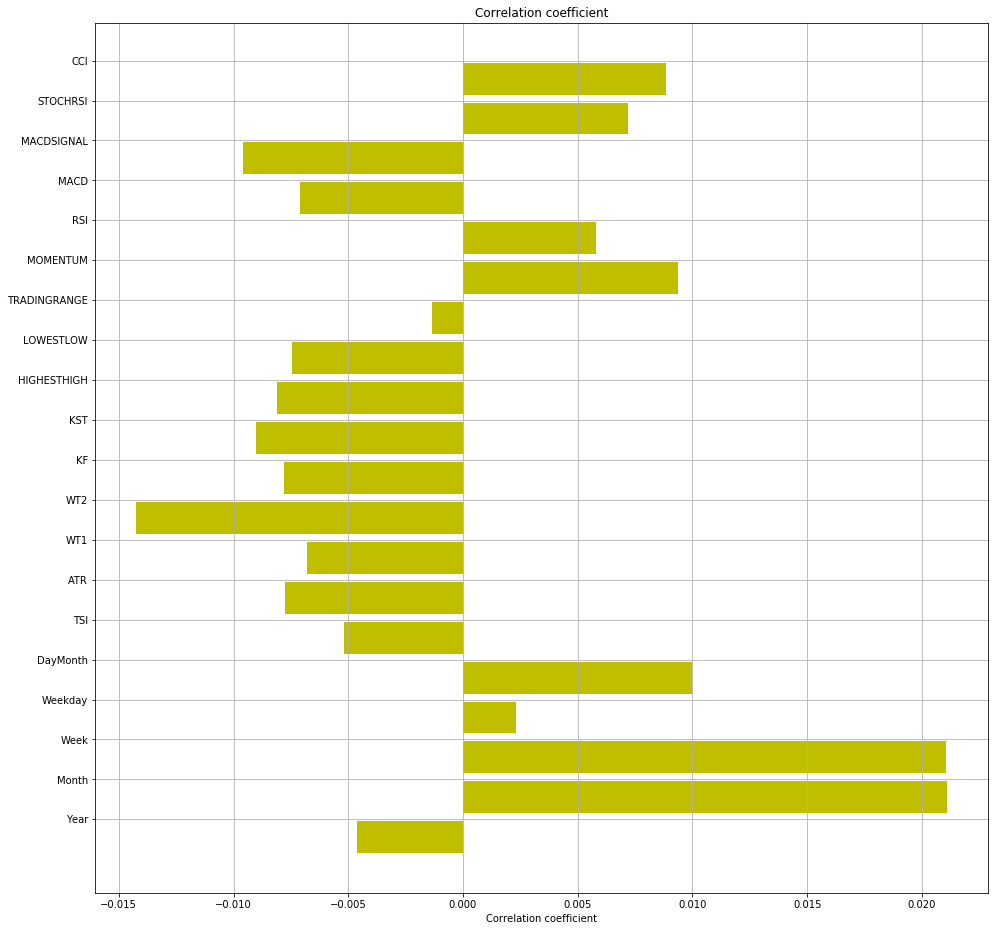

In [79]:
df = data_merged.dropna()
# Now let us look at the correlation coefficient of each of these variables
x_cols = [col for col in df.columns if col not in ['OPEN','HIGH','LOW','CLOSE','start_price','end_price','endtime',
                                                   'time_diff_hours','pct_change','weighted_target','signal','weight']]

target_col = 'signal'
labels = []
values = []
for col in x_cols:
    labels.append(col)
    values.append(np.corrcoef(df[col].values, df[target_col].values)[0,1])
    
ind = np.arange(len(labels))
width = 0.9
fig, ax = plt.subplots(figsize=(16,16))
plt.grid(True)
rects = ax.barh(ind, np.array(values), color='y')
ax.set_yticks(ind+((width)/2.))
ax.set_yticklabels(labels, rotation='horizontal')
ax.set_xlabel("Correlation coefficient")
ax.set_title("Correlation coefficient")
#autolabel(rects)
plt.show()


# trading rules 

In [143]:
#df = calc_MNE(data_merged[data_merged.time_diff_hours>0])
#df['MNE_timedelta'] = (df.MNE_time - df.index).astype('timedelta64[h]').values
df['Price_diff_end_start'] = (df.end_price-df.start_price)*df.signal
print('-Mean MNE time in hours: ' + str(round(df.MNE_timedelta.mean(),5)))
print('-Numer of zero MNE: ' + str(df.OPEN[df.MNE_timedelta==0].count()))
print('--Rows in processed file: ' + str(len(df)) + '\n--Rows in original file: ' + str(len(EURUSD_1H)))
print('---Mean MNE in pips: ' + str(round(df.MNE_distance_from_start.mean(),5)))
print('---Take Profit in pips: ' + str(profit))
print('---Mean Profit in pips (end to start): ' + str(round(df['Price_diff_end_start'].mean(),5)))

-Mean MNE time in hours: 3.18537
-Numer of zero MNE: 0
--Rows in processed file: 108238
--Rows in original file: 108238
---Mean MNE in pips: 0.00081
---Take Profit in pips: 0.0016
---Mean Profit in pips (end to start): 0.00308


In [159]:
df_results = df
df_results.dropna(inplace=True)
mean_holding_time = round(df_results.time_diff_hours.mean(),2)
file = 'results_hold_' + str(mean_holding_time) + '_profit_' + str(profit) + '.pkl'
df_results.to_pickle(file)

In [ ]:
from ipywidgets import interact

def plot_trade(i):
    i = int(i)
    EURUSD_temp = data_merged.iloc[i:int(1+i+data_merged['time_diff_hours'][i])]
    # start plotting
    from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
    init_notebook_mode(connected=True)
    data = [go.Candlestick(x=EURUSD_temp.index, open=EURUSD_temp['OPEN'],high=EURUSD_temp['HIGH'],low=EURUSD_temp['LOW'],
                          close=EURUSD_temp['CLOSE'])]
    py.offline.iplot(data,filename='basic_candle2')
    
def signalgenerator_wavetrend(df):
    time = []
    signal = []
    pos = False
    long = False
    for i in range(len(df)):
        if i == 0:
            continue
        # Entry
        if (df['WT1'][i-1]<df['WT2'][i-1]) and (df['WT1'][i]>=df['WT2'][i]) and (df['WT1'][i] <=-45):
            time.append(df.index[i])
            pos = True
            long = True
            signal.append(1)
            continue
        elif (df['WT1'][i-1]>df['WT2'][i-1]) and (df['WT1'][i]<=df['WT2'][i]) and (df['WT1'][i] >=45):
            time.append(df.index[i])
            pos = True
            long = False
            signal.append(-1)
            continue
        #if pos and long and (df['WT1'][i-1]>df['WT2'][i-1]) and (df['WT1'][i]<=df['WT2'][i]):
        #    pos = False
        #    time.append(df.index[i])
        #    signal.append(0)
        #if pos and not long and (df['WT1'][i-1]<df['WT2'][i-1]) and (df['WT1'][i]>=df['WT2'][i]):
        #    pos = False
        #    time.append(df.index[i])
        #    signal.append(0)
            
    d = {'time': time, 'wavetrend_signal': signal}
    df = pd.DataFrame(data=d)
    df.index = df['time']
    df = df.drop(['time'],axis=1)
    return df

def signalgenerator_stochrsi(df):
    time = []
    signal = []
    pos = False
    long = False
    for i in range(len(df)):
        if i == 0:
            continue
        # Entry
        if (df['STOCHRSI'][i-1]<df['STOCHRSI'][i]) and (df['STOCHRSI'][i] <=10) and (df['STOCHRSI'][i-2]<df['STOCHRSI'][i-1]):
            time.append(df.index[i])
            pos = True
            long = True
            signal.append(1)
            continue
        elif (df['STOCHRSI'][i-1]>df['STOCHRSI'][i]) and (df['STOCHRSI'][i] >=90) and (df['STOCHRSI'][i-2]>df['STOCHRSI'][i-1]):
            time.append(df.index[i])
            pos = True
            long = False
            signal.append(-1)
            continue
        #if pos and long and (df['WT1'][i-1]>df['WT2'][i-1]) and (df['WT1'][i]<=df['WT2'][i]):
        #    pos = False
        #    time.append(df.index[i])
        #    signal.append(0)
        #if pos and not long and (df['WT1'][i-1]<df['WT2'][i-1]) and (df['WT1'][i]>=df['WT2'][i]):
        #    pos = False
        #    time.append(df.index[i])
        #    signal.append(0)
            
    d = {'time': time, 'stochrsi_signal': signal}
    df = pd.DataFrame(data=d)
    df.index = df['time']
    df = df.drop(['time'],axis=1)
    return df

In [ ]:
interact(plot_trade, i='1');

# wavetrend generator

In [ ]:
wt_signal = signalgenerator_wavetrend(data_merged)
signal_wt_df = data_merged.merge(wt_signal, left_index=True,right_index =True, how='inner')
gainz = sum( abs(signal_wt_df['end_price']-signal_wt_df['start_price'])*10000 )
print('---WaveTrend: '+ str(len(signal_wt_df.query('signal == wavetrend_signal'))) + ' out of: '+str(len(signal_wt_df))+ ' correct with: ' + str(round(gainz,5)) + ' pips')

# stochrsi generator

In [ ]:
srsi_signal = signalgenerator_stochrsi(data_merged)
signal_srsi_df = data_merged.merge(srsi_signal, left_index=True,right_index =True, how='inner')
gainz = sum( abs(signal_srsi_df['end_price']-signal_srsi_df['start_price'])*10000 )
print('---WaveTrend: '+ str(len(signal_srsi_df.query('signal == stochrsi_signal'))) + ' out of: '+str(len(signal_srsi_df))+ ' correct with: ' + str(round(gainz,5)) + ' pips')

# mixed wavetrend and stochrsi

In [ ]:
signal_overall = data_merged.merge(wt_signal, left_index=True,right_index =True, how='left').merge(srsi_signal, left_index=True,right_index =True, how='left')
signal_overall['stochrsi_signal'] = signal_overall['stochrsi_signal'].fillna(method='ffill')
#signal_overall = signal_overall.dropna()
signal_overall = signal_overall.query('wavetrend_signal == stochrsi_signal')
print('---WaveTrend: '+ str(len(signal_overall.query('signal == wavetrend_signal'))) + ' out of: '+str(len(signal_overall))+ ' correct')

In [ ]:
df = signal_overall
# Now let us look at the correlation coefficient of each of these variables
x_cols = [col for col in df.columns if col not in ['OPEN','HIGH','LOW','CLOSE','start_price','end_price',
                                                   'time_diff_hours','pct_change','weighted_target','signal','weight',]]

target_col = 'signal'
labels = []
values = []
for col in x_cols:
    labels.append(col)
    values.append(np.corrcoef(df[col].values, df[target_col].values)[0,1])
    
ind = np.arange(len(labels))
width = 0.9
fig, ax = plt.subplots(figsize=(16,16))
plt.grid(True)
rects = ax.barh(ind, np.array(values), color='y')
ax.set_yticks(ind+((width)/2.))
ax.set_yticklabels(labels, rotation='horizontal')
ax.set_xlabel("Correlation coefficient")
ax.set_title("Correlation coefficient")
#autolabel(rects)
plt.show()
